In [ ]:
# !cp /kaggle/input/data-bowl-2019-external-data/*.py /kaggle/working

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
import jupytools.syspath
def ignore(*args, **kwargs): pass
warnings.warn = ignore
jupytools.syspath.add('..')

In [7]:
!pip install lightgbm xgboost

     |████████████████████████████████| 1.2MB 319kB/s eta 0:00:01
     |████████████████████████████████| 142.8MB 13.6MB/s eta 0:00:01


In [8]:
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold

import selection
import utils as U
from metric import optimize_rounding_bounds, make_cappa_metric
from training import EnsembleTrainer, get_default_config
from normalize import normalize

In [9]:
non_train_cols = ['installation_id', 'game_session', 'accuracy_group']

def read_dataset():
    X_trn = pd.read_pickle('/tmp/X_trn.pickle')
    X_tst = pd.read_pickle('/tmp/X_tst.pickle')
    selector = selection.FeatureSelection(
        rules=[('nonzero', selection.non_zero_rows_and_cols)],
        ignore_cols=non_train_cols)
    features = selector.select(X_trn)
    X_trn['is_test'] = 0
    X_tst['is_test'] = 1
    dataset = pd.concat([X_trn, X_tst])
    return dataset, features

## Adversarial CV

In [4]:
# https://www.kaggle.com/poteman/sampling-train-data-and-use-prediction-as-feature

In [5]:
def accuracy(y_true, y_pred, t=0.5):
    from sklearn.metrics import balanced_accuracy_score
    y_hat = [0 if y < t else 1 for y in y_pred]
    return balanced_accuracy_score(y_true, y_hat)

In [6]:
def adv_cv(dataset, features, algo='lightgbm', target='is_test', config=None):
    trainer = EnsembleTrainer(
        algo=algo, eval_metric='rmse', 
        cv_metrics={'auc': roc_auc_score, 'acc': accuracy})
    fold = GroupKFold(n_splits=5)
    config = config or get_default_config(algo)
    U.set_nested(config, 'model_params.feature_fraction', 0.8)
    U.set_nested(config, 'model_params.bagging_fraction', 0.75)
    U.set_nested(config, 'model_params.bagging_freq', 1)
    result = trainer.train(dataset, features, fold, target=target)
    return result

In [7]:
def plot_feat_imp(fi, n=200, figsize=(45, 15)):
    f, ax = plt.subplots(1, 1, figsize=figsize, facecolor='white')
    fi.sort_values(ascending=False).head(n).plot.bar(ax=ax)
    ax.set_title('Most Important Features Different Between Train and Test ')

## Train As Is

In [8]:
dataset, features = read_dataset()
result_default = adv_cv(dataset, features)

Excluding from consideration: ['installation_id', 'game_session', 'accuracy_group']
Applying feature selection rule: nonzero
Selected features: 987 of 1020
Keeping only features, selected by every rule.
Final number of features changed from 1020 to 987
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 0.136071	val's rmse: 0.149706
[200]	trn's rmse: 0.109352	val's rmse: 0.132836
[300]	trn's rmse: 0.0976695	val's rmse: 0.130231
[400]	trn's rmse: 0.0906311	val's rmse: 0.130499
Early stopping, best iteration is:
[320]	trn's rmse: 0.0960409	val's rmse: 0.130103
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 0.137923	val's rmse: 0.143164
[200]	trn's rmse: 0.111448	val's rmse: 0.127664
[300]	trn's rmse: 0.099767	val's rmse: 0.125134
[400]	trn's rmse: 0.0926373	val's rmse: 0.125135
Early stopping, best iteration is:
[306]	trn's rmse: 0.0992168	val's rmse: 0.125065
Running k-fold 3 of 5


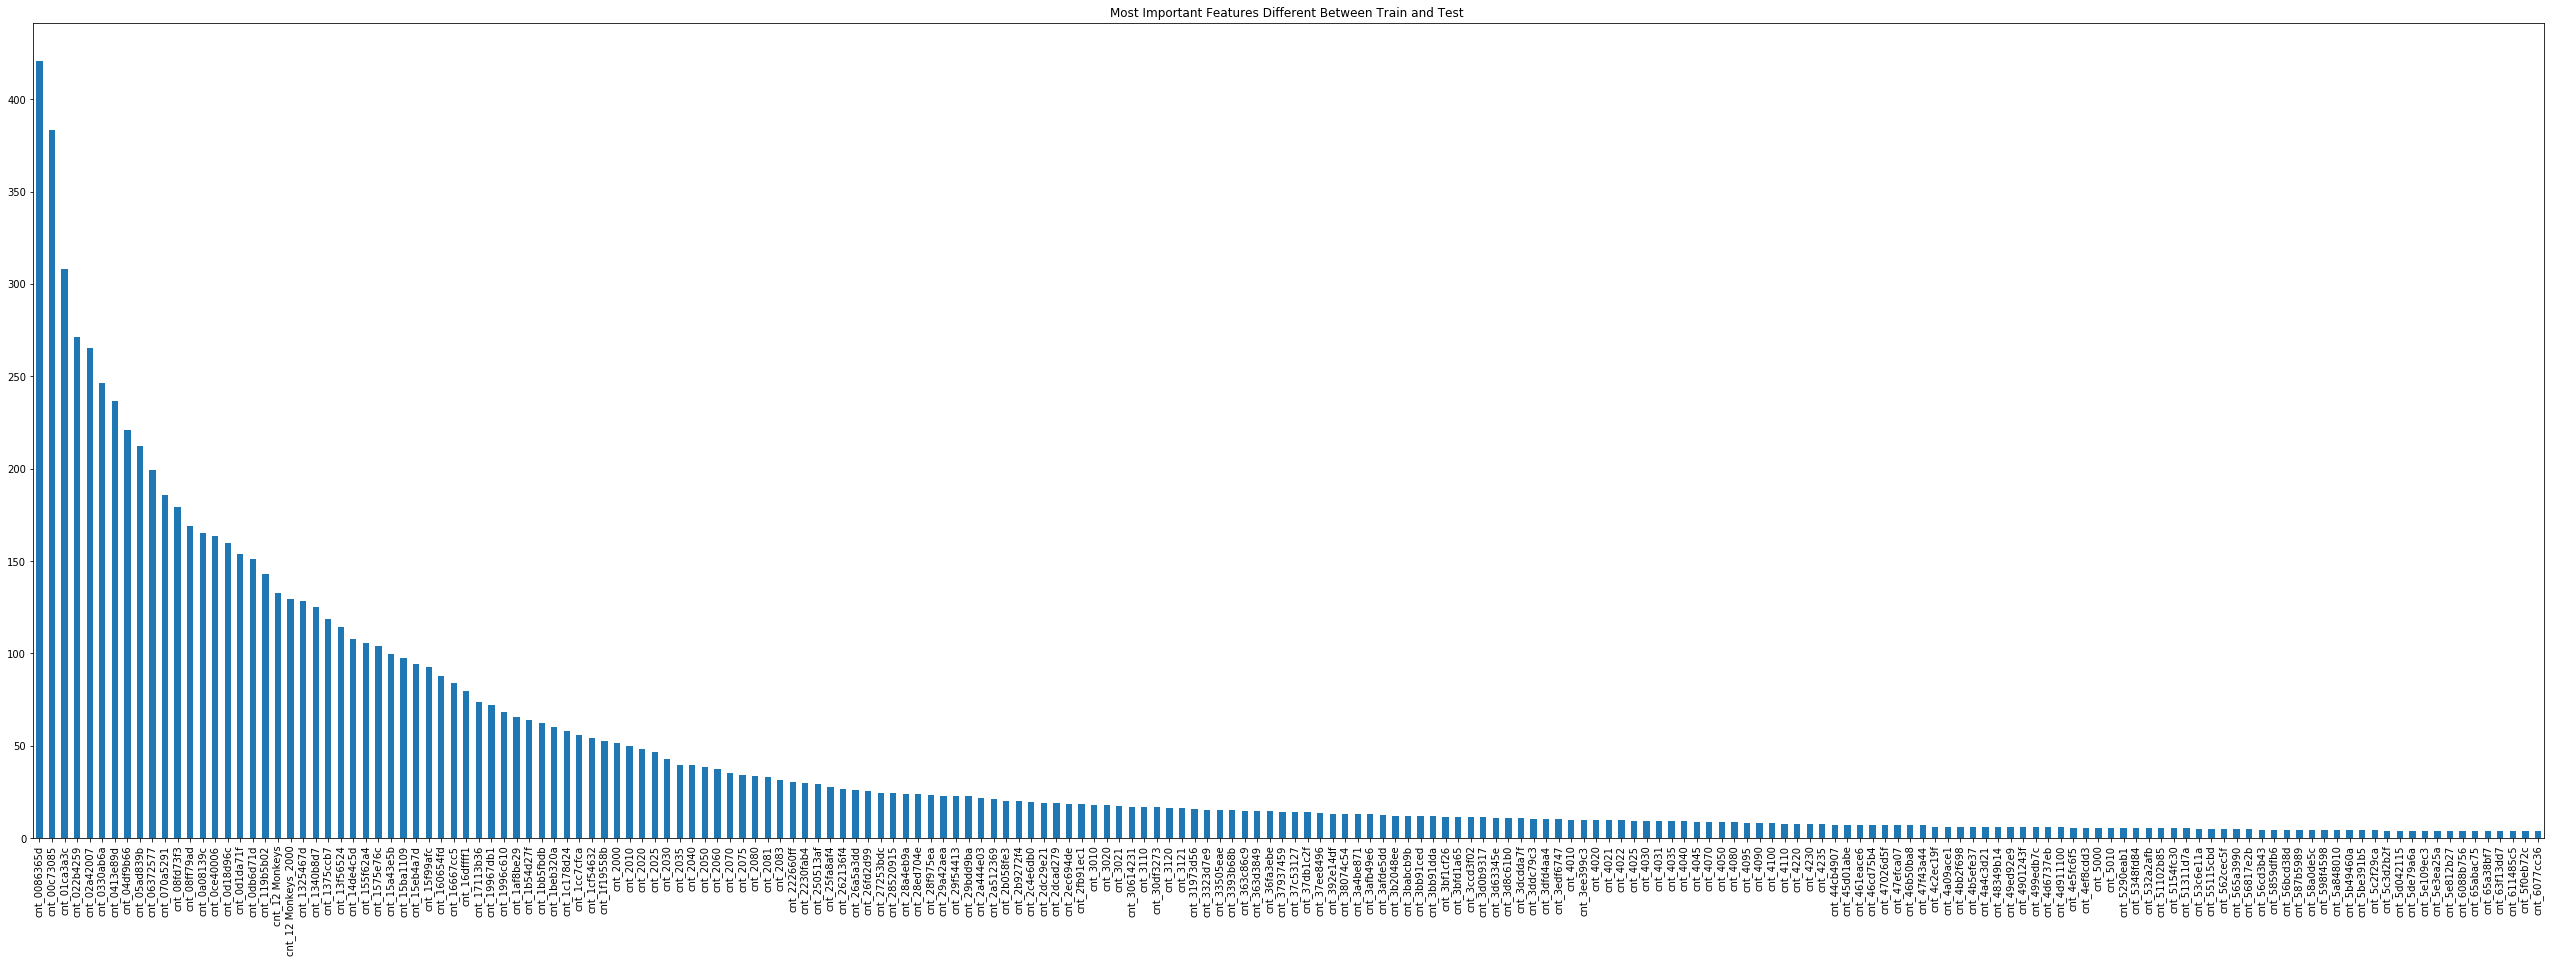

In [9]:
plot_feat_imp(result_default.fi)

In [49]:
import numpy as np
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb

In [76]:
dataset, features = read_dataset()
dataset = dataset.sample(dataset.shape[0]).reset_index(drop=True)

Excluding from consideration: ['installation_id', 'game_session', 'accuracy_group']
Applying feature selection rule: nonzero
Selected features: 987 of 1020
Keeping only features, selected by every rule.
Final number of features changed from 1020 to 987


In [39]:
dataset, features = read_dataset()
index = np.random.permutation(dataset.index)
dataset = dataset[index]
fold = GroupKFold(n_splits=5)
X = dataset[features]
y = dataset['is_test']
groups = dataset['installation_id']
oof = np.zeros(X.shape[0], dtype=np.float32)
cv = []

for i, (trn_idx, val_idx) in enumerate(fold.split(X, y, groups), 1):
    U.log(f'Running fold #{i}')
    x_trn, y_trn = X.iloc[trn_idx], y.iloc[trn_idx]
    x_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    logreg = LogisticRegression(n_jobs=12)
    logreg.fit(x_trn, y_trn)
    probs = logreg.predict_proba(x_val)[:, 1]
    oof[val_idx] = probs
    cv.append(roc_auc_score(y_val, probs))

Running fold #1
Running fold #2
Running fold #3
Running fold #4
Running fold #5


In [78]:
import joblib
estimator = xgb.XGBRFClassifier(
    gpu_id=1, tree_method='gpu_hist', max_depth=6, 
    learning_rate=1, n_estimators=250)
selector = RFECV(estimator, cv=5, verbose=1)
selector.fit(X, y)
joblib.dump(selector, 'selector.joblib')

Fitting estimator with 987 features.
Fitting estimator with 986 features.
Fitting estimator with 985 features.
Fitting estimator with 984 features.
Fitting estimator with 983 features.
Fitting estimator with 982 features.
Fitting estimator with 981 features.
Fitting estimator with 980 features.
Fitting estimator with 979 features.
Fitting estimator with 978 features.
Fitting estimator with 977 features.
Fitting estimator with 976 features.
Fitting estimator with 975 features.
Fitting estimator with 974 features.
Fitting estimator with 973 features.
Fitting estimator with 972 features.
Fitting estimator with 971 features.
Fitting estimator with 970 features.
Fitting estimator with 969 features.
Fitting estimator with 968 features.
Fitting estimator with 967 features.
Fitting estimator with 966 features.
Fitting estimator with 965 features.
Fitting estimator with 964 features.
Fitting estimator with 963 features.
Fitting estimator with 962 features.
Fitting estimator with 961 features.
F

Fitting estimator with 715 features.
Fitting estimator with 714 features.
Fitting estimator with 713 features.
Fitting estimator with 712 features.
Fitting estimator with 711 features.
Fitting estimator with 710 features.
Fitting estimator with 709 features.
Fitting estimator with 708 features.
Fitting estimator with 707 features.
Fitting estimator with 706 features.
Fitting estimator with 705 features.
Fitting estimator with 704 features.
Fitting estimator with 703 features.
Fitting estimator with 702 features.
Fitting estimator with 701 features.
Fitting estimator with 700 features.
Fitting estimator with 699 features.
Fitting estimator with 698 features.
Fitting estimator with 697 features.
Fitting estimator with 696 features.
Fitting estimator with 695 features.
Fitting estimator with 694 features.
Fitting estimator with 693 features.
Fitting estimator with 692 features.
Fitting estimator with 691 features.
Fitting estimator with 690 features.
Fitting estimator with 689 features.
F

Fitting estimator with 493 features.
Fitting estimator with 492 features.
Fitting estimator with 491 features.
Fitting estimator with 490 features.
Fitting estimator with 489 features.
Fitting estimator with 488 features.
Fitting estimator with 487 features.
Fitting estimator with 486 features.
Fitting estimator with 485 features.
Fitting estimator with 484 features.
Fitting estimator with 483 features.
Fitting estimator with 482 features.
Fitting estimator with 481 features.
Fitting estimator with 480 features.
Fitting estimator with 479 features.
Fitting estimator with 478 features.
Fitting estimator with 477 features.
Fitting estimator with 476 features.
Fitting estimator with 475 features.
Fitting estimator with 474 features.
Fitting estimator with 473 features.
Fitting estimator with 472 features.
Fitting estimator with 471 features.
Fitting estimator with 470 features.
Fitting estimator with 469 features.
Fitting estimator with 468 features.
Fitting estimator with 467 features.
F

Fitting estimator with 271 features.
Fitting estimator with 270 features.
Fitting estimator with 269 features.
Fitting estimator with 268 features.
Fitting estimator with 267 features.
Fitting estimator with 266 features.
Fitting estimator with 265 features.
Fitting estimator with 264 features.
Fitting estimator with 263 features.
Fitting estimator with 262 features.
Fitting estimator with 261 features.
Fitting estimator with 260 features.
Fitting estimator with 259 features.
Fitting estimator with 258 features.
Fitting estimator with 257 features.
Fitting estimator with 256 features.
Fitting estimator with 255 features.
Fitting estimator with 254 features.
Fitting estimator with 253 features.
Fitting estimator with 252 features.
Fitting estimator with 251 features.
Fitting estimator with 250 features.
Fitting estimator with 249 features.
Fitting estimator with 248 features.
Fitting estimator with 247 features.
Fitting estimator with 246 features.
Fitting estimator with 245 features.
F

Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 fe

Fitting estimator with 811 features.
Fitting estimator with 810 features.
Fitting estimator with 809 features.
Fitting estimator with 808 features.
Fitting estimator with 807 features.
Fitting estimator with 806 features.
Fitting estimator with 805 features.
Fitting estimator with 804 features.
Fitting estimator with 803 features.
Fitting estimator with 802 features.
Fitting estimator with 801 features.
Fitting estimator with 800 features.
Fitting estimator with 799 features.
Fitting estimator with 798 features.
Fitting estimator with 797 features.
Fitting estimator with 796 features.
Fitting estimator with 795 features.
Fitting estimator with 794 features.
Fitting estimator with 793 features.
Fitting estimator with 792 features.
Fitting estimator with 791 features.
Fitting estimator with 790 features.
Fitting estimator with 789 features.
Fitting estimator with 788 features.
Fitting estimator with 787 features.
Fitting estimator with 786 features.
Fitting estimator with 785 features.
F

Fitting estimator with 589 features.
Fitting estimator with 588 features.
Fitting estimator with 587 features.
Fitting estimator with 586 features.
Fitting estimator with 585 features.
Fitting estimator with 584 features.
Fitting estimator with 583 features.
Fitting estimator with 582 features.
Fitting estimator with 581 features.
Fitting estimator with 580 features.
Fitting estimator with 579 features.
Fitting estimator with 578 features.
Fitting estimator with 577 features.
Fitting estimator with 576 features.
Fitting estimator with 575 features.
Fitting estimator with 574 features.
Fitting estimator with 573 features.
Fitting estimator with 572 features.
Fitting estimator with 571 features.
Fitting estimator with 570 features.
Fitting estimator with 569 features.
Fitting estimator with 568 features.
Fitting estimator with 567 features.
Fitting estimator with 566 features.
Fitting estimator with 565 features.
Fitting estimator with 564 features.
Fitting estimator with 563 features.
F

Fitting estimator with 367 features.
Fitting estimator with 366 features.
Fitting estimator with 365 features.
Fitting estimator with 364 features.
Fitting estimator with 363 features.
Fitting estimator with 362 features.
Fitting estimator with 361 features.
Fitting estimator with 360 features.
Fitting estimator with 359 features.
Fitting estimator with 358 features.
Fitting estimator with 357 features.
Fitting estimator with 356 features.
Fitting estimator with 355 features.
Fitting estimator with 354 features.
Fitting estimator with 353 features.
Fitting estimator with 352 features.
Fitting estimator with 351 features.
Fitting estimator with 350 features.
Fitting estimator with 349 features.
Fitting estimator with 348 features.
Fitting estimator with 347 features.
Fitting estimator with 346 features.
Fitting estimator with 345 features.
Fitting estimator with 344 features.
Fitting estimator with 343 features.
Fitting estimator with 342 features.
Fitting estimator with 341 features.
F

Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
Fitting estimator with 140 features.
Fitting estimator with 139 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fitting estimator with 136 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
F

Fitting estimator with 906 features.
Fitting estimator with 905 features.
Fitting estimator with 904 features.
Fitting estimator with 903 features.
Fitting estimator with 902 features.
Fitting estimator with 901 features.
Fitting estimator with 900 features.
Fitting estimator with 899 features.
Fitting estimator with 898 features.
Fitting estimator with 897 features.
Fitting estimator with 896 features.
Fitting estimator with 895 features.
Fitting estimator with 894 features.
Fitting estimator with 893 features.
Fitting estimator with 892 features.
Fitting estimator with 891 features.
Fitting estimator with 890 features.
Fitting estimator with 889 features.
Fitting estimator with 888 features.
Fitting estimator with 887 features.
Fitting estimator with 886 features.
Fitting estimator with 885 features.
Fitting estimator with 884 features.
Fitting estimator with 883 features.
Fitting estimator with 882 features.
Fitting estimator with 881 features.
Fitting estimator with 880 features.
F

Fitting estimator with 684 features.
Fitting estimator with 683 features.
Fitting estimator with 682 features.
Fitting estimator with 681 features.
Fitting estimator with 680 features.
Fitting estimator with 679 features.
Fitting estimator with 678 features.
Fitting estimator with 677 features.
Fitting estimator with 676 features.
Fitting estimator with 675 features.
Fitting estimator with 674 features.
Fitting estimator with 673 features.
Fitting estimator with 672 features.
Fitting estimator with 671 features.
Fitting estimator with 670 features.
Fitting estimator with 669 features.
Fitting estimator with 668 features.
Fitting estimator with 667 features.
Fitting estimator with 666 features.
Fitting estimator with 665 features.
Fitting estimator with 664 features.
Fitting estimator with 663 features.
Fitting estimator with 662 features.
Fitting estimator with 661 features.
Fitting estimator with 660 features.
Fitting estimator with 659 features.
Fitting estimator with 658 features.
F

Fitting estimator with 462 features.
Fitting estimator with 461 features.
Fitting estimator with 460 features.
Fitting estimator with 459 features.
Fitting estimator with 458 features.
Fitting estimator with 457 features.
Fitting estimator with 456 features.
Fitting estimator with 455 features.
Fitting estimator with 454 features.
Fitting estimator with 453 features.
Fitting estimator with 452 features.
Fitting estimator with 451 features.
Fitting estimator with 450 features.
Fitting estimator with 449 features.
Fitting estimator with 448 features.
Fitting estimator with 447 features.
Fitting estimator with 446 features.
Fitting estimator with 445 features.
Fitting estimator with 444 features.
Fitting estimator with 443 features.
Fitting estimator with 442 features.
Fitting estimator with 441 features.
Fitting estimator with 440 features.
Fitting estimator with 439 features.
Fitting estimator with 438 features.
Fitting estimator with 437 features.
Fitting estimator with 436 features.
F

Fitting estimator with 240 features.
Fitting estimator with 239 features.
Fitting estimator with 238 features.
Fitting estimator with 237 features.
Fitting estimator with 236 features.
Fitting estimator with 235 features.
Fitting estimator with 234 features.
Fitting estimator with 233 features.
Fitting estimator with 232 features.
Fitting estimator with 231 features.
Fitting estimator with 230 features.
Fitting estimator with 229 features.
Fitting estimator with 228 features.
Fitting estimator with 227 features.
Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
F

Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 987 features.
Fitting estimator with 986 features.
Fitting estimator with 985 features.
Fitting estimator with 984 features.
Fitting estimator with 983 features.
Fitting estimator with 982 features.
Fitting estimator with 981 features.
Fitting estimator with 980 features.
Fitting estimator with 979 features.
Fitting estimator with 978 features.
Fitting estimator with 977 features.
Fitting estimator with 976 features.
Fitting estimator with 9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [94]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

estimator = xgb.XGBRFClassifier(gpu_id=1, tree_method='gpu_hist',
                                max_depth=6, learning_rate=1,
                                n_estimators=1000)

folds = StratifiedKFold()
X_sim = X[X.columns[~selector.support_]]
cv = []

for trn_idx, val_idx in folds.split(X_sim, y):
    x_trn, y_trn = X_sim.iloc[trn_idx], y.iloc[trn_idx]
    x_val, y_val = X_sim.iloc[val_idx], y.iloc[val_idx]
    trees = clone(estimator)
    trees.fit(x_trn, y_trn)
    probs = trees.predict_proba(x_val)[:, 1]
    cv.append(roc_auc_score(y_val, probs))

In [100]:
joblib.dump(X.columns[~selector.support_].tolist(), '/tmp/bowl2019/features.joblib')

['/tmp/bowl2019/features.joblib']

## Train With Standard Scaler

In [83]:
def standard_scaler(dataset, features, stats=None):
    stats = stats or {}
    for feature in features:
        if feature not in stats:
            m = dataset[feature].mean()
            s = dataset[feature].std() + 1e-8
            stats[feature] = {'mean': m, 'std': s}
        dataset[feature] = (dataset[feature] - stats[feature]['mean'])/stats[feature]['std']

In [85]:
dataset, features = read_dataset()
cnt_features = U.starts_with(features, 'cnt_')
standard_scaler(dataset, cnt_features)
result_std = adv_cv(dataset, features)

Excluding from consideration: ['installation_id', 'game_session', 'accuracy_group']
Applying feature selection rule: nonzero
Selected features: 979 of 1000
Keeping only features, selected by every rule.
Final number of features changed from 1000 to 979
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 0.135851	val's rmse: 0.149037
[200]	trn's rmse: 0.108907	val's rmse: 0.132182
[300]	trn's rmse: 0.0979937	val's rmse: 0.130499
[400]	trn's rmse: 0.0909648	val's rmse: 0.130817
Early stopping, best iteration is:
[346]	trn's rmse: 0.0945109	val's rmse: 0.130329
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 0.137842	val's rmse: 0.142271
[200]	trn's rmse: 0.111327	val's rmse: 0.127362
[300]	trn's rmse: 0.100263	val's rmse: 0.125283
[400]	trn's rmse: 0.0931696	val's rmse: 0.125248
Early stopping, best iteration is:
[326]	trn's rmse: 0.098185	val's rmse: 0.125222
Running k-fold 3 of 5
T

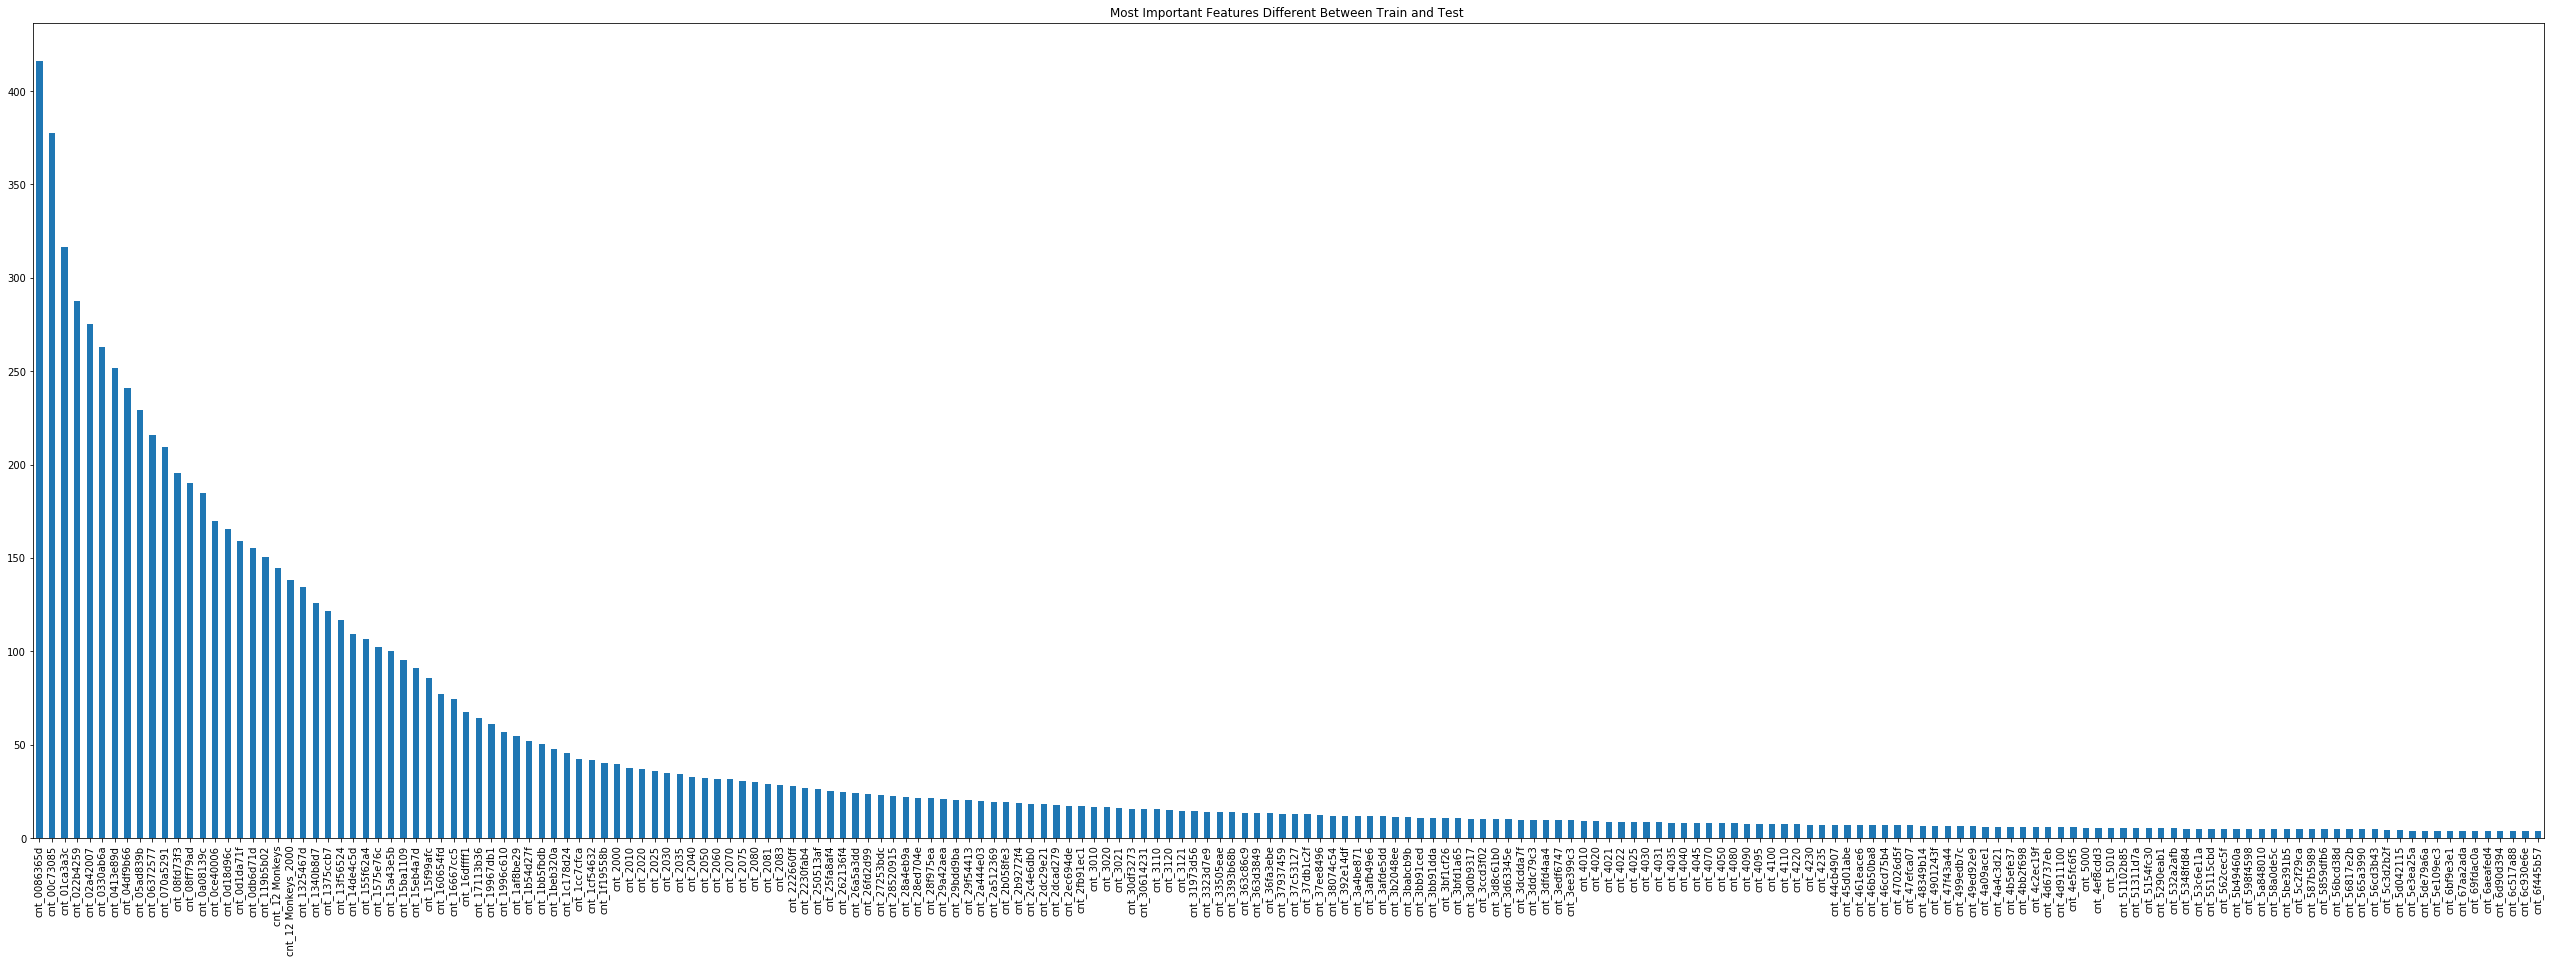

In [86]:
plot_feat_imp(result_std.fi)

## Train With Grouped Normalization: Session Title

In [87]:
def standard_scaler_grouped(dataset, features, grouping_key='session_title'):
    def _standard_scaler(x):
        m, s = x.mean(), x.std()
        return (x - m)/(s + 1e-8)
    groups = dataset.groupby(grouping_key)
    for feature in features:
        dataset[feature] = groups[feature].transform(_standard_scaler)

In [88]:
dataset, features = read_dataset()
cnt_features = U.starts_with(features, 'cnt_')
standard_scaler_grouped(dataset, cnt_features)
result_std_grouped = adv_cv(dataset, features)

Excluding from consideration: ['installation_id', 'game_session', 'accuracy_group']
Applying feature selection rule: nonzero
Selected features: 979 of 1000
Keeping only features, selected by every rule.
Final number of features changed from 1000 to 979
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 0.135801	val's rmse: 0.150711
[200]	trn's rmse: 0.107723	val's rmse: 0.133589
[300]	trn's rmse: 0.0959247	val's rmse: 0.131676
Early stopping, best iteration is:
[292]	trn's rmse: 0.0966954	val's rmse: 0.131577
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 0.138182	val's rmse: 0.143324
[200]	trn's rmse: 0.1105	val's rmse: 0.127191
[300]	trn's rmse: 0.0988164	val's rmse: 0.125276
[400]	trn's rmse: 0.091364	val's rmse: 0.12522
Early stopping, best iteration is:
[353]	trn's rmse: 0.0946333	val's rmse: 0.125146
Running k-fold 3 of 5
Training until validation scores don't improve for 1

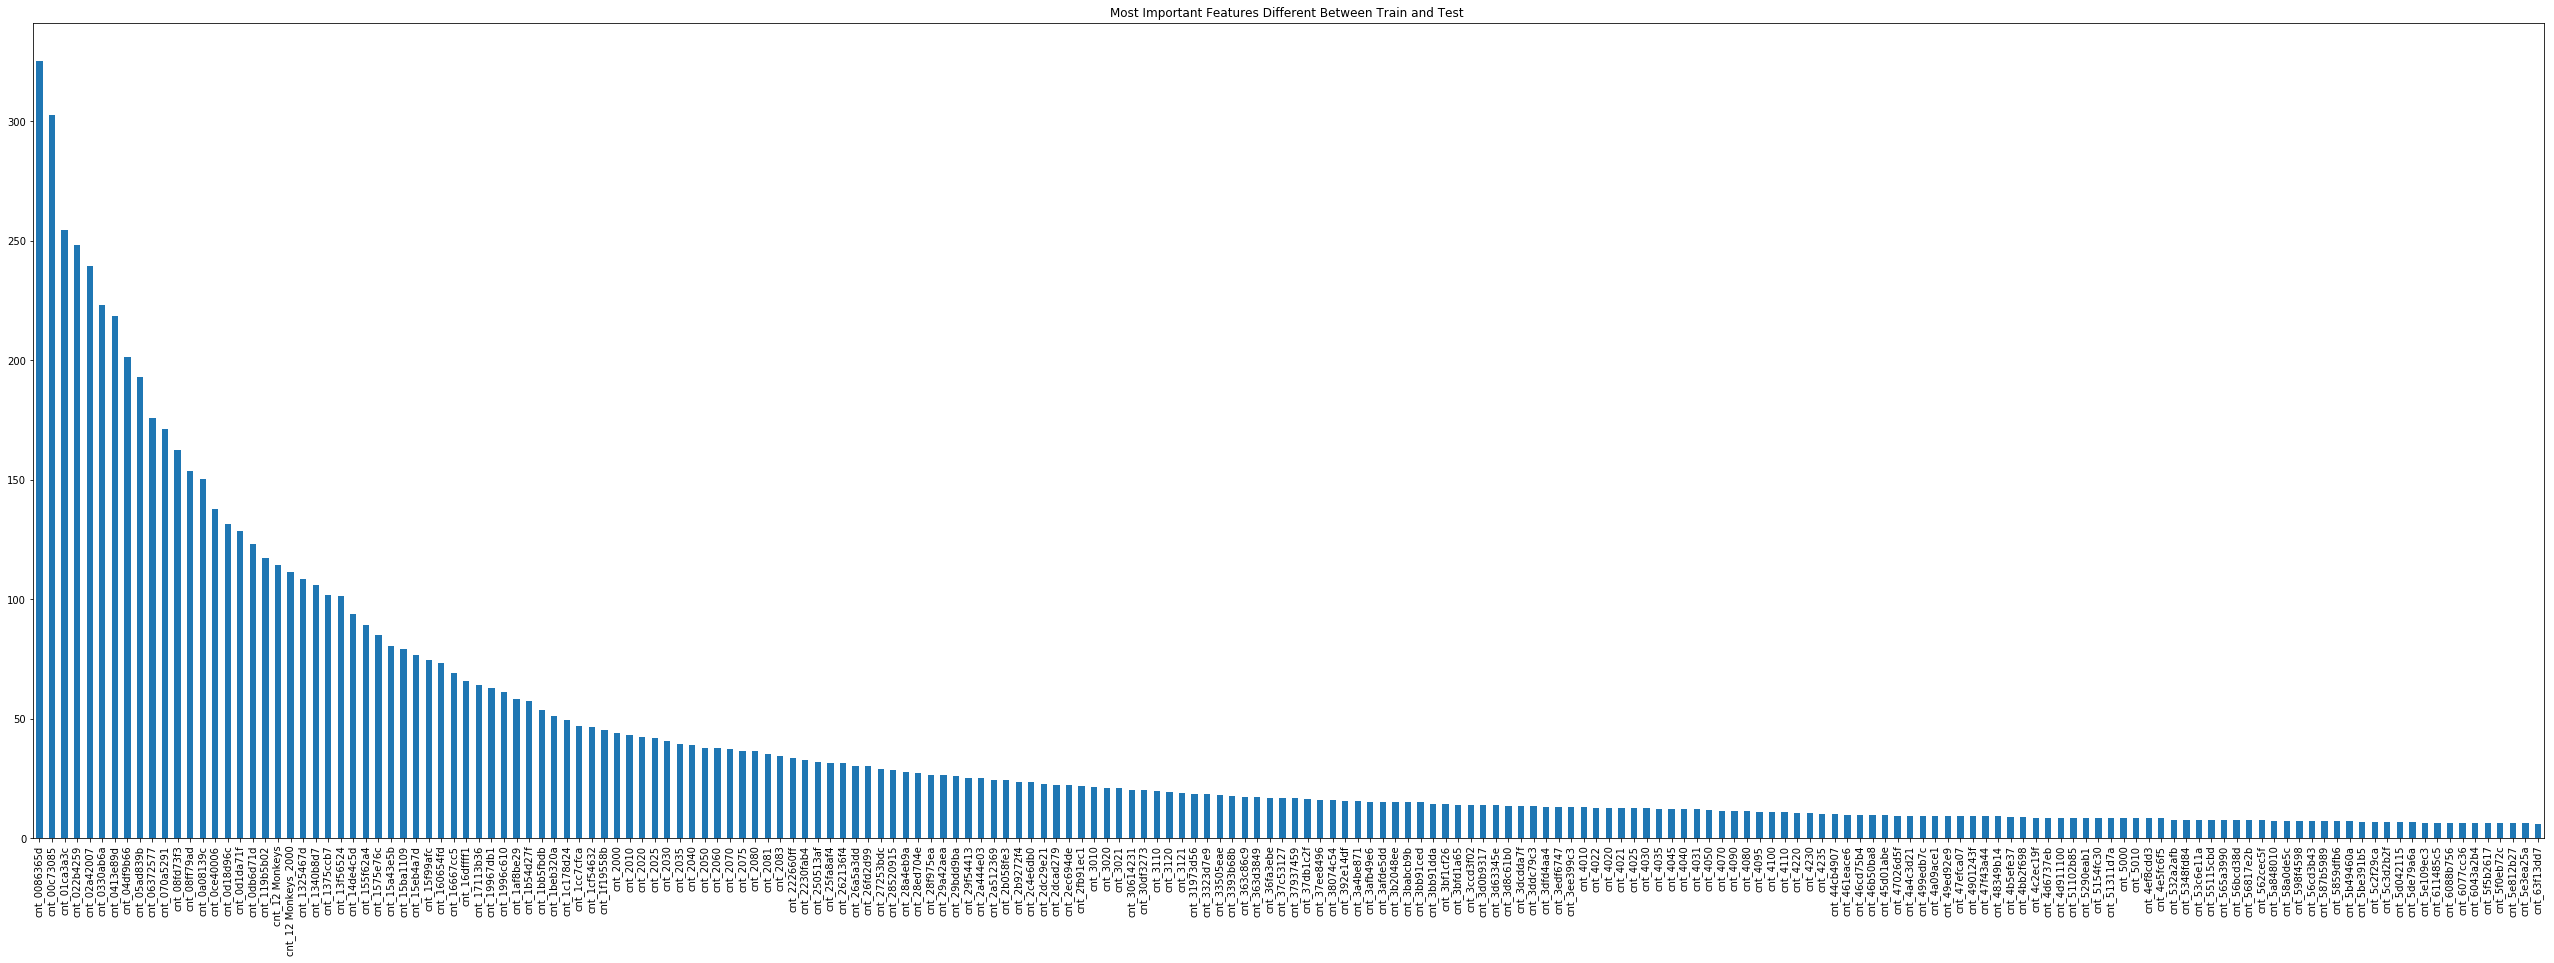

In [89]:
plot_feat_imp(result_std_grouped.fi)

## Train With Grouped Normalization: Installation ID

In [90]:
dataset, features = read_dataset()
cnt_features = U.starts_with(features, 'cnt_')
standard_scaler_grouped(dataset, cnt_features, grouping_key='installation_id')
result_std_inst = adv_cv(dataset, features)

Excluding from consideration: ['installation_id', 'game_session', 'accuracy_group']
Applying feature selection rule: nonzero
Selected features: 979 of 1000
Keeping only features, selected by every rule.
Final number of features changed from 1000 to 979
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 0.135429	val's rmse: 0.147269
[200]	trn's rmse: 0.110989	val's rmse: 0.132008
[300]	trn's rmse: 0.101346	val's rmse: 0.130277
[400]	trn's rmse: 0.0952236	val's rmse: 0.130695
Early stopping, best iteration is:
[310]	trn's rmse: 0.10066	val's rmse: 0.13019
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 0.137599	val's rmse: 0.139772
[200]	trn's rmse: 0.113269	val's rmse: 0.125512
[300]	trn's rmse: 0.103673	val's rmse: 0.123906
[400]	trn's rmse: 0.097534	val's rmse: 0.124206
Early stopping, best iteration is:
[310]	trn's rmse: 0.102975	val's rmse: 0.12385
Running k-fold 3 of 5
Trainin

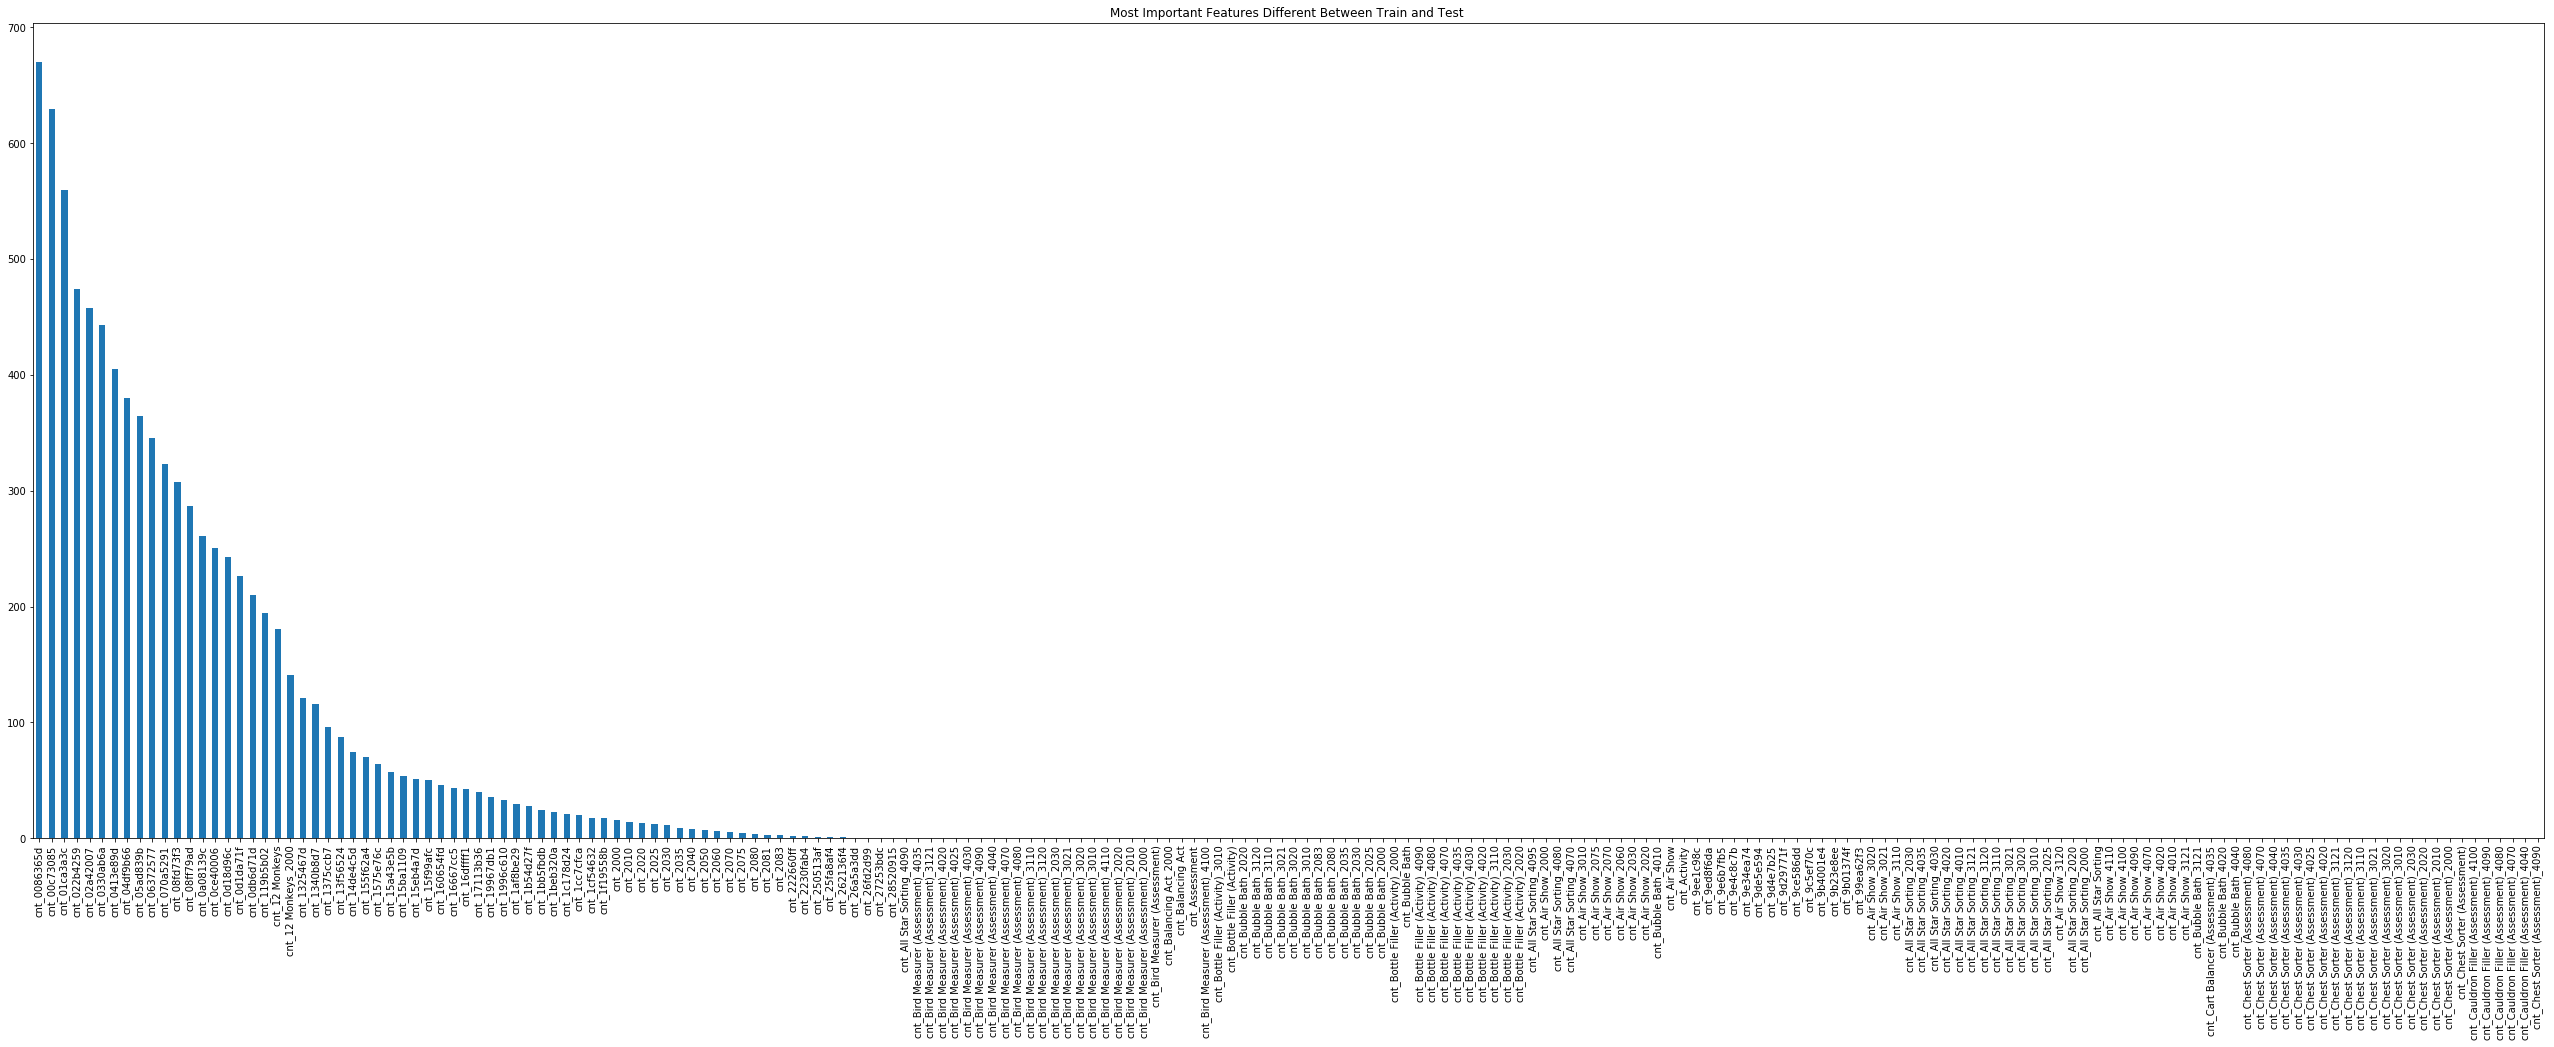

In [92]:
plot_feat_imp(result_std_inst.fi)

## Adversarial CV with Normalization

In [10]:
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as models

In [13]:
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 2


In [14]:
def root_mean_squared_error(y_true, y_pred):
    K = tf.keras.backend
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [15]:
dataset, features = read_dataset()
target_col = 'is_test'
cat_cols = ['session_title']
num_cols = [f for f in features if f not in cat_cols]

Excluding from consideration: ['installation_id', 'game_session', 'accuracy_group']
Applying feature selection rule: nonzero
Selected features: 987 of 1020
Keeping only features, selected by every rule.
Final number of features changed from 1020 to 987


In [16]:
normalize(dataset, num_cols, grouping_key='session_title')

In [23]:
def build_model(num_cols, cat_cols, cat_sizes, 
                output_size, output_act, loss):
    
    def prepare_input(data):
        return [data[num_cols]] + [data[col].T for col in cat_cols]
    
    def numerical(input_size):
        i = L.Input(shape=(input_size,))
        x = L.Dense(2048, activation='relu', use_bias=False)(i)
        x = L.BatchNormalization()(x)
        x = L.Dropout(0.5)(x)
        m = models.Model(inputs=i, outputs=x)
        return m
    
    def categorical(cat_sizes):
        inputs, embeds = [], []
        for cat_size in cat_sizes:
            emb_sz = min(50, cat_size // 2)
            i = L.Input(shape=(1,))
            x = L.Embedding(output_dim=emb_sz, input_dim=cat_size)(i)
            inputs.append(i)
            embeds.append(x)
        if len(embeds) > 1:
            x = L.concatenate(embeds)
        x = L.Flatten()(x)
        m = models.Model(inputs=inputs, outputs=x)
        return m
    
    with tf.device('/GPU:1'):
        num = numerical(len(num_cols))
        cat = categorical(cat_sizes)
        x = L.concatenate(num.outputs + cat.outputs)
        x = L.Dense(1024, activation='relu', use_bias=False)(x)
        x = L.BatchNormalization()(x)
        x = L.Dropout(0.25)(x)
        x = L.Dense(512, activation='relu', use_bias=False)(x)
        x = L.BatchNormalization()(x)
        x = L.Dropout(0.25)(x)
        x = L.Dense(256, activation='relu', use_bias=False)(x)
        x = L.BatchNormalization()(x)
        x = L.Dropout(0.25)(x)
        x = L.Dense(output_size, activation=output_act)(x)
        model = models.Model(inputs=num.inputs + cat.inputs, outputs=x)
        model.compile(optimizer='rmsprop', loss=root_mean_squared_error)
        
    return model, prepare_input

In [34]:
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

In [36]:
folds = GroupKFold(n_splits=5)
dataset = dataset.sample(dataset.shape[0])
group = dataset['installation_id']
X, y = dataset[features], dataset['is_test']
oof = np.zeros(len(y), dtype=np.float32)

for i, (trn_idx, val_idx) in enumerate(folds.split(X, y, group), 1):
    print(f'Training fold #{i}')
    x_trn, y_trn = X.iloc[trn_idx], y.iloc[trn_idx]
    x_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    net, split_input = build_model(cat_cols=cat_cols, num_cols=num_cols, 
                                   cat_sizes=[5], loss='binary_crossentropy',
                                   output_size=1, output_act='sigmoid')
    net.fit(x=split_input(x_trn), y=y_trn,
            validation_data=(split_input(x_val), y_val),
            epochs=50, batch_size=2560,
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
    probs = net.predict(split_input(x_val))
    oof[val_idx] = probs.ravel()

Training fold #1


W0118 19:43:50.272850 139973985421120 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>


Train on 14952 samples, validate on 3738 samples
Epoch 1/50
14952/14952 [==============================] - 1s 73us/sample - loss: 0.5258 - val_loss: 0.7847
Epoch 2/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.3625 - val_loss: 0.4550
Epoch 3/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.3243 - val_loss: 0.4084
Epoch 4/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2899 - val_loss: 0.3474
Epoch 5/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2814 - val_loss: 0.3057
Epoch 6/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2779 - val_loss: 0.3059
Epoch 7/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2608 - val_loss: 0.3275
Epoch 8/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2545 - val_loss: 0.2948
Epoch 9/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2393 - val_l

W0118 19:44:10.848000 139973985421120 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>


Training fold #2


W0118 19:44:12.792496 139973985421120 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>


Train on 14952 samples, validate on 3738 samples
Epoch 1/50
14952/14952 [==============================] - 1s 74us/sample - loss: 0.4953 - val_loss: 0.3067
Epoch 2/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.3623 - val_loss: 0.3151
Epoch 3/50
14952/14952 [==============================] - 0s 30us/sample - loss: 0.2910 - val_loss: 0.2770
Epoch 4/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.3062 - val_loss: 0.2765
Epoch 5/50
14952/14952 [==============================] - 0s 30us/sample - loss: 0.2778 - val_loss: 0.2511
Epoch 6/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2723 - val_loss: 0.2295
Epoch 7/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2727 - val_loss: 0.2299
Epoch 8/50
14952/14952 [==============================] - 0s 30us/sample - loss: 0.2737 - val_loss: 0.2254
Epoch 9/50
14952/14952 [==============================] - 0s 30us/sample - loss: 0.2715 - val_l

W0118 19:44:29.509002 139973985421120 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>


Training fold #3


W0118 19:44:30.876902 139973985421120 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>


Train on 14952 samples, validate on 3738 samples
Epoch 1/50
14952/14952 [==============================] - 1s 74us/sample - loss: 0.5140 - val_loss: 0.8456
Epoch 2/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.3611 - val_loss: 0.4865
Epoch 3/50
14952/14952 [==============================] - 0s 30us/sample - loss: 0.3038 - val_loss: 0.3754
Epoch 4/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2993 - val_loss: 0.2785
Epoch 5/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2811 - val_loss: 0.2300
Epoch 6/50
14952/14952 [==============================] - 0s 30us/sample - loss: 0.2700 - val_loss: 0.2348
Epoch 7/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2527 - val_loss: 0.2227
Epoch 8/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2443 - val_loss: 0.2203
Epoch 9/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2336 - val_l

W0118 19:44:48.228302 139973985421120 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>


Training fold #4


W0118 19:44:49.613497 139973985421120 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>


Train on 14952 samples, validate on 3738 samples
Epoch 1/50
14952/14952 [==============================] - 1s 73us/sample - loss: 0.5264 - val_loss: 0.4187
Epoch 2/50
14952/14952 [==============================] - 0s 28us/sample - loss: 0.3695 - val_loss: 0.3393
Epoch 3/50
14952/14952 [==============================] - 0s 27us/sample - loss: 0.3109 - val_loss: 0.2878
Epoch 4/50
14952/14952 [==============================] - 0s 28us/sample - loss: 0.2966 - val_loss: 0.2519
Epoch 5/50
14952/14952 [==============================] - 0s 28us/sample - loss: 0.2890 - val_loss: 0.2417
Epoch 6/50
14952/14952 [==============================] - 0s 30us/sample - loss: 0.2966 - val_loss: 0.2340
Epoch 7/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2925 - val_loss: 0.2293
Epoch 8/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2851 - val_loss: 0.2267
Epoch 9/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2892 - val_l

W0118 19:45:05.239400 139973985421120 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>


Training fold #5


W0118 19:45:06.640980 139973985421120 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>


Train on 14952 samples, validate on 3738 samples
Epoch 1/50
14952/14952 [==============================] - 1s 74us/sample - loss: 0.4995 - val_loss: 0.5830
Epoch 2/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.3369 - val_loss: 0.3205
Epoch 3/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.3090 - val_loss: 0.2728
Epoch 4/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2876 - val_loss: 0.2440
Epoch 5/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2678 - val_loss: 0.2328
Epoch 6/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2753 - val_loss: 0.2283
Epoch 7/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2580 - val_loss: 0.2272
Epoch 8/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2562 - val_loss: 0.2234
Epoch 9/50
14952/14952 [==============================] - 0s 29us/sample - loss: 0.2563 - val_l

W0118 19:45:25.770260 139973985421120 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>


In [38]:
roc_auc_score(y, oof)

0.5175835217637084

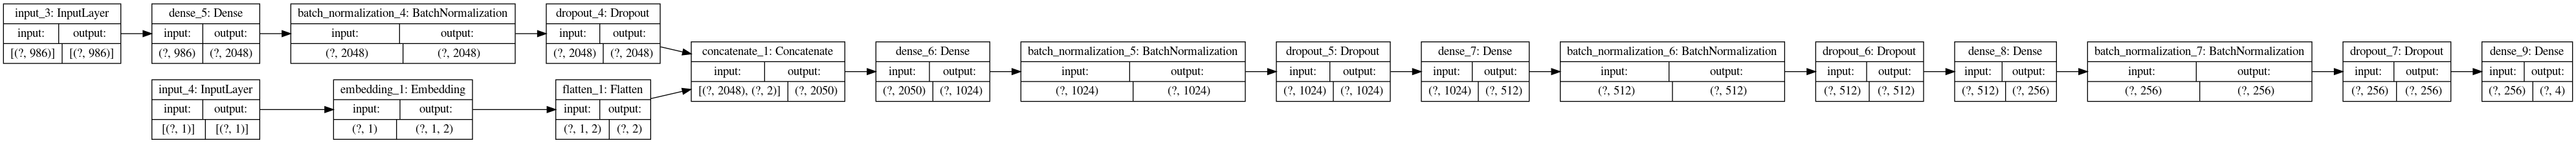

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(net, show_shapes=True, rankdir='LR')